# ANDES Demonstration of `DGPRCTExt` on IEEE 14-Bus System

Prepared by Jinning Wang. Last revised 12 September 2021.

## Background

Voltage signal is set manually to demonstrate `DGPRCTExt`.

In the modified IEEE 14-bus system, 10 `PVD1` are conencted to `Bus4`, and 1 `DGPRCTExt` is added aiming at `PVD1_2`.

## Conclusion

`DGPRCTExt` can be used to implement protection on `DG` models, where the voltage signal can be manipulated manually. This feature allows co-simulation where you can input the external voltage signal into ADNES by `set` function.

In [ ]:
!python3 -m pip install andes
!python -m pip install kvxopt
# !pip install -r requirements.txt
!pip install -U PyYAML

     |████████████████████████████████| 7.5 MB 6.5 MB/s 
     |████████████████████████████████| 12.2 MB 35.1 MB/s 
     |████████████████████████████████| 149 kB 46.0 MB/s 
     |████████████████████████████████| 81 kB 8.1 MB/s 
     |████████████████████████████████| 46 kB 3.1 MB/s 
     |████████████████████████████████| 86 kB 3.2 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
  Created wheel for andes: filename=andes-1.6.2-py3-none-any.whl size=2927376 sha256=401b4759c266ec24346ceabb78d26c88165a86b1ba2bdb56d9e9f7984daf5ffd
  Stored in directory: /root/.cache/pip/wheels/0f/6d/d5/2233a6bf9ce0c3e8ac4e5cc667fc032145fa8540cd1b0723a6
Successfully built andes
     |████████████████████████████████| 596 kB 9.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import andes
from andes.utils.paths import get_case
import numpy as np
import matplotlib.pyplot as plt
andes.config_logger(stream_level=30)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RecoverFlag = 0

# W.O control

## init

In [ ]:
!andes misc -C

"/content/ieee39_wenqiv2_out.txt" removed.
"/content/ieee39_wenqiv2_out.lst" removed.
"/content/ieee39_wenqiv2_out.npz" removed.


In [ ]:
ss = andes.load(get_case('ieee39_test.xlsx'),
                setup=False,
                no_output=False)

In [ ]:
Pm=np.array([ -0.19983394, -0.25653884, -0.25191885, -0.10242008, -0.34510365,\
         0.23206371,  0.4404325 ,  0.5896664 ,  0.26257738, -0.36892462])
dim_PQ = 19
dim_PV = 13
dim_bus = 39
adjust_ratio = 1
ss.PV.p0.v[0:9] = np.array(ss.PV.p0.v[0:9])*adjust_ratio + Pm[0:9]
ss.Slack.p0.v[0] = np.array(ss.Slack.p0.v[0])*adjust_ratio + Pm[-1]



In [ ]:
fault_time = 1
ss.setup()

True

In [ ]:
# use constant power model for PQ
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0

ss.PFlow.run()

True

In [ ]:
ratiogen =0.7
num_PVD = 10
ss.PVD1.gammap.v[0:num_PVD] = np.ones(num_PVD )*(1-ratiogen)
ss.PVD1.gammaq.v[0:num_PVD] = np.ones(num_PVD )*(1-ratiogen)
ss.GENROU.gammap.v[0:num_PVD] = np.ones(num_PVD )*ratiogen
ss.GENROU.gammaq.v[0:num_PVD] = np.ones(num_PVD )*ratiogen

In [ ]:
ss.PVD1.Ipcmd.lim.allow_adjust = True
ss.PVD1.Iqcmd.lim.allow_adjust = True
ss.PVD1.ialim.v[0:10] = ss.PVD1.ialim.v[0:10]*300


In [ ]:
ss.TDS.config.tf = fault_time
ss.TDS.run()

GENROU (xl <= xd2) out of typical upper limit.

   idx    | values | limit
----------+--------+------
 GENROU_5 | 0.054  | 0.039
 GENROU_9 | 0.030  | 0.021


Suspect initialization issue! Simulation may crash!

   Name     | Var. Value | Eqn. Mismatch
------------+------------+--------------
 v Bus 30.0 | 1.048      | -0.003       
 v Bus 31.0 | 1.040      | -0.003       
 v Bus 32.0 | 0.983      | -0.003       
 v Bus 33.0 | 0.997      | -0.003       
 v Bus 34.0 | 1.012      | -0.003       
 v Bus 35.0 | 1.049      | -0.003       
 v Bus 36.0 | 1.063      | -0.003       
 v Bus 37.0 | 1.028      | -0.003       
 v Bus 38.0 | 1.026      | -0.003       
 v Bus 39.0 | 1.030      | -0.003       


Initialization failed!!
If you are developing a new model, check the initialization with
   andes -v 10 run -r tds --init /content/drive/MyDrive/Colab Notebooks/andes/examples0313/cases0313/ieee39_wenqiv2.xlsx
Otherwise, check the variables that are initialized out of limits.


 32%|#############7                             | 32/100 [00:00<00:00, 95.01%/s]


True

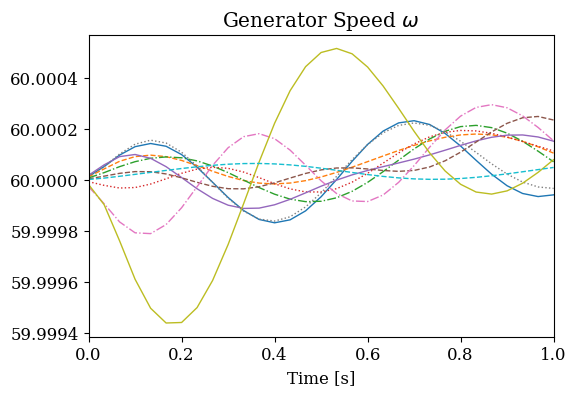

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feab7353b50>)

In [ ]:
ss.TDS.plt.plot(ss.GENROU.omega,
                ycalc=lambda x:60*x,
                title='Generator Speed $\omega$')

## step load change

In [ ]:
print(ss.GENROU.tm0.v)
print(ss.GENROU.p0.v)


[1.61144648 3.95486241 4.38266088 4.35681178 3.31598831 4.86732746
 4.23289961 4.20602153 6.00460929 0.09476272]
[1.61011624 3.83093281 4.3736568  4.35230594 3.31442744 4.7124446
 4.22830275 4.19276648 5.99380417 0.09435625]


In [ ]:
ss.GENROU.tm0.v[7]= ss.GENROU.tm0.v[7] - 2

In [ ]:


ss.TDS.config.tf = fault_time+10
ss.TDS.run()

100%|########################################| 100.0/100 [00:05<00:00, 17.90%/s]


True

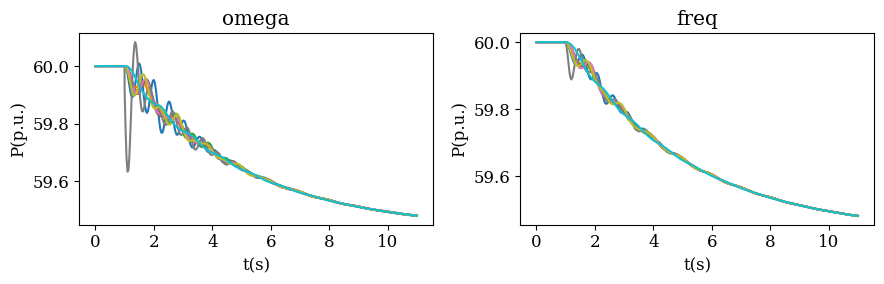

In [ ]:
ListTime = ss.dae.ts.t
ListFreq = ss.dae.ts.y[:,ss.BusFreq.f.a]*60 #Hz
ListOmega= ss.dae.ts.x[:,ss.GENROU.omega.a]*60 #Hz
plt_idx = np.arange(0,10)
TimeStep_start = 0
TimeStep = np.size(ListTime)
#  1100
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListOmega[TimeStep_start:TimeStep, plt_idx], label='RotorFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.title('omega')
# plt.legend()

plt.subplot(1,2,2)
# TimeStep_start = 560
# TimeStep = 800
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListFreq[TimeStep_start:TimeStep, plt_idx], label='BusFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.title('freq')

# plt.legend()
fig.tight_layout()

# With Linear Control

In [ ]:

!pip install mat4py
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gym
import tensorflow as tf
import os
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import sys
from gym import spaces
from gym.utils import seeding
import copy
from mat4py import loadmat
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
max_action=np.array([[0.19606592, 0.2190382 , 0.22375287, 0.0975513 , 0.29071101,
        0.22091283, 0.38759459, 0.56512538, 0.24151538, 0.29821917]],dtype=np.float32)*1.
linear_coff=np.array([[ 2.2347659,   2.720281 ,   2.4595585,  43.59709  ,   5.7675405,
          2.3880444, 156.02136  ,  12.0558605,   2.8042254,  25.922562  ]], dtype=np.float32)*1
max_action = max_action.reshape(-1)
linear_coff = linear_coff.reshape(-1)

In [ ]:
def Action_linear(pref0_init, linear_coff, idexs, max_action):
    action_nonconstrain =  - (ss.PVD1.fHz.v[idexs]-60)*linear_coff[idexs]

    action=max_action[idexs]-tf.nn.relu(max_action[idexs]-action_nonconstrain)+tf.nn.relu(-max_action[idexs]-action_nonconstrain)
    return pref0_init[idexs]+action

## init

In [ ]:
!andes misc -C

"/content/ieee39_wenqiv2_out.txt" removed.
"/content/ieee39_wenqiv2_out.lst" removed.
"/content/ieee39_wenqiv2_out.npz" removed.


In [ ]:
ss = andes.load(get_case('ieee39_test.xlsx'),
                setup=False,
                no_output=False)

In [ ]:
Pm=np.array([ -0.19983394, -0.25653884, -0.25191885, -0.10242008, -0.34510365,\
         0.23206371,  0.4404325 ,  0.5896664 ,  0.26257738, -0.36892462])
dim_PQ = 19
dim_PV = 13
dim_bus = 39
adjust_ratio = 1
ss.PV.p0.v[0:9] = np.array(ss.PV.p0.v[0:9])*adjust_ratio + Pm[0:9]
ss.Slack.p0.v[0] = np.array(ss.Slack.p0.v[0])*adjust_ratio + Pm[-1]



In [ ]:
ss.BusFreq.Tf.v[0:10] = 0.05*np.ones(10)
ss.BusFreq.Tw.v[0:10] = 0.03*np.ones(10)


In [ ]:
fault_time = 1

ss.setup()

True

In [ ]:
# use constant power model for PQ
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0

ss.PFlow.run()

True

In [ ]:
ratiogen =0.7
num_PVD = 10
ss.PVD1.gammap.v[0:num_PVD] = np.ones(num_PVD )*(1-ratiogen)
ss.PVD1.gammaq.v[0:num_PVD] = np.ones(num_PVD )*(1-ratiogen)
ss.GENROU.gammap.v[0:num_PVD] = np.ones(num_PVD )*ratiogen
ss.GENROU.gammaq.v[0:num_PVD] = np.ones(num_PVD )*ratiogen

In [ ]:
ss.PVD1.Ipcmd.lim.allow_adjust = True
ss.PVD1.Iqcmd.lim.allow_adjust = True
ss.PVD1.ialim.v[0:10] = ss.PVD1.ialim.v[0:10]*300


In [ ]:
ss.TDS.config.tf = fault_time
ss.TDS.run()

GENROU (xl <= xd2) out of typical upper limit.

   idx    | values | limit
----------+--------+------
 GENROU_5 | 0.054  | 0.039
 GENROU_9 | 0.030  | 0.021


Suspect initialization issue! Simulation may crash!

   Name     | Var. Value | Eqn. Mismatch
------------+------------+--------------
 v Bus 30.0 | 1.048      | -0.003       
 v Bus 31.0 | 1.040      | -0.003       
 v Bus 32.0 | 0.983      | -0.003       
 v Bus 33.0 | 0.997      | -0.003       
 v Bus 34.0 | 1.012      | -0.003       
 v Bus 35.0 | 1.049      | -0.003       
 v Bus 36.0 | 1.063      | -0.003       
 v Bus 37.0 | 1.028      | -0.003       
 v Bus 38.0 | 1.026      | -0.003       
 v Bus 39.0 | 1.030      | -0.003       


Initialization failed!!
If you are developing a new model, check the initialization with
   andes -v 10 run -r tds --init /content/drive/MyDrive/Colab Notebooks/andes/examples0313/cases0313/ieee39_wenqiv2.xlsx
Otherwise, check the variables that are initialized out of limits.


 32%|#############7                             | 32/100 [00:00<00:01, 51.13%/s]


True

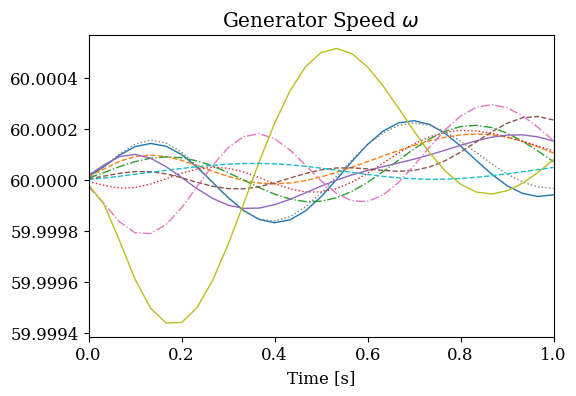

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feab344da10>)

In [ ]:
ss.TDS.plt.plot(ss.GENROU.omega,
                ycalc=lambda x:60*x,
                title='Generator Speed $\omega$')

## Apply the control

In [ ]:

PQStepIdx = 16
PQInit = np.array(ss.PQ.Ppf.v[PQStepIdx]).copy()
PQ_after = 6

ss.PQ.Ppf.v[PQStepIdx] = PQ_after



In [ ]:
pref0_init = ss.PVD1.pref0.v.copy()

In [ ]:
step_t = 0.02
tstart =fault_time
TimeLength = tstart+10
idexs = np.arange(0,10)
for t in np.arange(tstart, TimeLength, step_t):
    ss.PVD1.pref0.v[idexs] = Action_linear(pref0_init, linear_coff, idexs, max_action)
    print(ss.PVD1.pref0.v[idexs] )
    ss.TDS.config.tf = t
    ss.TDS.run(tstep = 0.01)
    # ss.TDS.run(tstep = 0.01, max_iter = 50)

[0.69002279 1.64156482 1.87416455 1.86001772 1.41971277 2.01924032
 1.78570825 1.7966394  2.56878915 0.03941641]
100%|#####################################| 100.0/100 [00:00<00:00, 43617.97%/s]
[0.69002279 1.64156482 1.87416455 1.86001772 1.41971277 2.01924032
 1.78570825 1.7966394  2.56878915 0.03941641]
100%|#######################################| 100.0/100 [00:00<00:00, 434.55%/s]
[0.71832057 1.66252303 1.8940662  1.96282528 1.46929586 2.04219784
 2.19972433 2.04902666 2.8102886  0.10331197]
100%|#######################################| 100.0/100 [00:00<00:00, 997.19%/s]
[0.7292464  1.67031421 1.90092067 1.96282528 1.48453074 2.04755489
 2.19972433 2.1017275  2.8102886  0.12873819]
100%|#######################################| 100.0/100 [00:00<00:00, 581.03%/s]
[0.74029158 1.67850817 1.90759818 1.96282528 1.49785524 2.05185462
 2.19972433 2.12012952 2.8102886  0.15544797]
100%|######################################| 100.0/100 [00:00<00:00, 1064.25%/s]
[0.75987945 1.6945675  1.92187

In [ ]:
if RecoverFlag:
    tstart =fault_time+10
    TimeLength = tstart+10
    ss.PQ.Ppf.v[PQStepIdx] = PQInit

    for t in np.arange(tstart, TimeLength, step_t):
        ss.PVD1.pref0.v[idexs] = Action_linear(pref0_init, linear_coff, idexs, max_action)
        ss.TDS.config.tf = t
        ss.TDS.run()

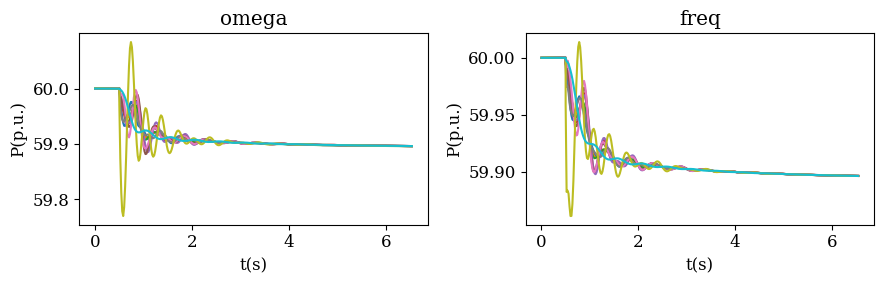

In [ ]:
ListTime = ss.dae.ts.t
ListFreq = ss.dae.ts.y[:,ss.BusFreq.f.a]*60 #Hz
ListOmega= ss.dae.ts.x[:,ss.GENROU.omega.a]*60 #Hz
plt_idx = np.arange(0,10)
TimeStep_start = 15
TimeStep = np.size(ListTime)-200
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListOmega[TimeStep_start:TimeStep, plt_idx], label='RotorFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.title('omega')
# plt.legend()

plt.subplot(1,2,2)
# TimeStep_start = 560
# TimeStep = 800
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListFreq[TimeStep_start:TimeStep, plt_idx], label='BusFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.title('freq')

# plt.legend()
fig.tight_layout()

## compare power command and output power

In [ ]:
ListTime = ss.dae.ts.t
ListPVDV = ss.dae.ts.y[:,ss.PVD1.v.a]
ListPVDI = ss.dae.ts.x[:,ss.PVD1.Ipout_y.a]
ListPVDPower = ListPVDV*ListPVDI
ListPVDPowerCMD = ss.dae.ts.y[:,ss.PVD1.Psum.a]

In [ ]:
np.size(ListTime )

535

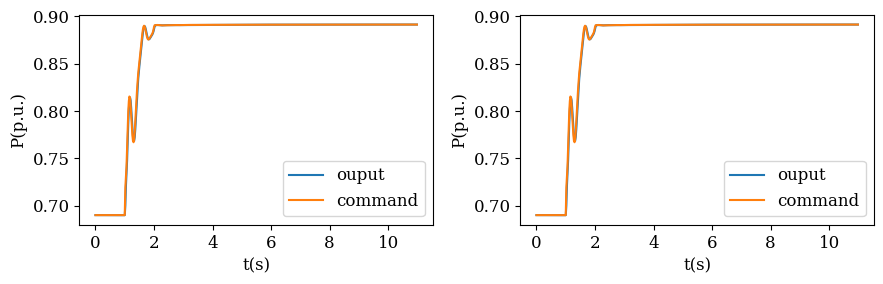

In [ ]:
plt_idx = [0]
TimeStep_start = 0
TimeStep = np.size(ListTime)
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListPVDPower[TimeStep_start:TimeStep, plt_idx], label='ouput')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListPVDPowerCMD[TimeStep_start:TimeStep, plt_idx], label='command')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.legend()

plt.subplot(1,2,2)
# TimeStep_start = 560
TimeStep = 800
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListPVDPower[TimeStep_start:TimeStep, plt_idx], label='ouput')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListPVDPowerCMD[TimeStep_start:TimeStep, plt_idx], label='command')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.legend()
fig.tight_layout()

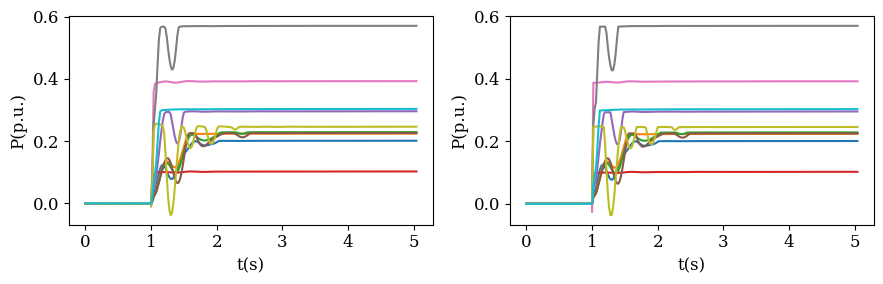

In [ ]:
plt_idx = np.arange(0, 10)
TimeStep_start = 0
TimeStep = np.size(ListTime)-300
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], \
         ListPVDPower[TimeStep_start:TimeStep, plt_idx]-ListPVDPower[0, plt_idx], label='ouput')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
# plt.legend()

plt.subplot(1,2,2)
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], \
         ListPVDPowerCMD[TimeStep_start:TimeStep, plt_idx]-ListPVDPower[0, plt_idx], label='command')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
# plt.legend()
fig.tight_layout()

## Compare omega

In [ ]:
ss.BusFreq.f

Algeb: BusFreq.f, a=[481 482 483 484 485 486 487 488 489 490 491], v=[0.99824888 0.99824886 0.99824888 0.99824903 0.99824899 0.99824916
 0.99824926 0.99824893 0.99824908 0.99824886 0.99824881], e=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.11022302e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]

In [ ]:
ListTime = ss.dae.ts.t
ListFreq = ss.dae.ts.y[:,ss.BusFreq.f.a]*60 #Hz
ListOmega= ss.dae.ts.x[:,ss.GENROU.omega.a]*60 #Hz


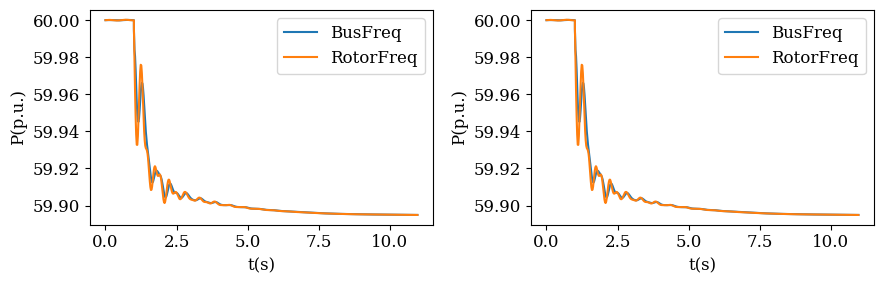

In [ ]:
plt_idx = [0]
TimeStep_start = 0
TimeStep = np.size(ListTime)
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListFreq[TimeStep_start:TimeStep, plt_idx], label='BusFreq')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListOmega[TimeStep_start:TimeStep, plt_idx], label='RotorFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.legend()

plt.subplot(1,2,2)
TimeStep_start = 0
TimeStep = np.size(ListTime)
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListFreq[TimeStep_start:TimeStep, plt_idx], label='BusFreq')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListOmega[TimeStep_start:TimeStep, plt_idx], label='RotorFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.legend()
fig.tight_layout()

# With NN

In [ ]:
import pickle

# load the data
f = open('Weights_RNN.pckl', 'rb')

[w_plus_RNN, b_plus_RNN, w_minus_RNN, b_minus_RNN]= pickle.load(f)
f.close()

In [ ]:
ones_frequency=tf.ones((10,20),dtype=tf.float32)

def Action_RNN(w_plus_RNN, b_plus_RNN, w_minus_RNN, b_minus_RNN, pref0_init, idexs, max_action):
    state =   tf.reshape(tf.constant((ss.PVD1.fHz.v-60),dtype=tf.float32), (1,-1))
    nonlinear_plus=K.sum(K.relu(K.dot(tf.linalg.diag(state),ones_frequency)+b_plus_RNN)\
                    *w_plus_RNN,axis=2)
    nonlinear_minus=K.sum(K.relu(-K.dot(tf.linalg.diag(state),ones_frequency)+b_minus_RNN)\
                    *w_minus_RNN,axis=2)
    action_nonconstrain=tf.reshape( nonlinear_plus+nonlinear_minus, -1).numpy()
    action = max_action[idexs]-tf.nn.relu(max_action[idexs]-action_nonconstrain[idexs])+tf.nn.relu(-max_action[idexs]-action_nonconstrain[idexs])
    return action

## init

In [ ]:
!andes misc -C

"/content/ieee39_wenqiv2_out.txt" removed.
"/content/ieee39_wenqiv2_out.lst" removed.
"/content/ieee39_wenqiv2_out.npz" removed.


In [ ]:
ss = andes.load(get_case('ieee39_test.xlsx'),
                setup=False,
                no_output=False)

In [ ]:
Pm=np.array([ -0.19983394, -0.25653884, -0.25191885, -0.10242008, -0.34510365,\
         0.23206371,  0.4404325 ,  0.5896664 ,  0.26257738, -0.36892462])
dim_PQ = 19
dim_PV = 13
dim_bus = 39
adjust_ratio = 1
ss.PV.p0.v[0:9] = np.array(ss.PV.p0.v[0:9])*adjust_ratio + Pm[0:9]
ss.Slack.p0.v[0] = np.array(ss.Slack.p0.v[0])*adjust_ratio + Pm[-1]



In [ ]:
ss.BusFreq.Tf.v[0:10] = 0.05*np.ones(10)
ss.BusFreq.Tw.v[0:10] = 0.03*np.ones(10)


In [ ]:
fault_time = 1

ss.setup()

True

In [ ]:
# use constant power model for PQ
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0

ss.PFlow.run()

True

In [ ]:
ratiogen =0.7
num_PVD = 10
ss.PVD1.gammap.v[0:num_PVD] = np.ones(num_PVD )*(1-ratiogen)
ss.PVD1.gammaq.v[0:num_PVD] = np.ones(num_PVD )*(1-ratiogen)
ss.GENROU.gammap.v[0:num_PVD] = np.ones(num_PVD )*ratiogen
ss.GENROU.gammaq.v[0:num_PVD] = np.ones(num_PVD )*ratiogen

In [ ]:
ss.PVD1.Ipcmd.lim.allow_adjust = True
ss.PVD1.Iqcmd.lim.allow_adjust = True
ss.PVD1.ialim.v[0:10] = ss.PVD1.ialim.v[0:10]*300


In [ ]:
ss.TDS.config.tf = fault_time
ss.TDS.run()

GENROU (xl <= xd2) out of typical upper limit.

   idx    | values | limit
----------+--------+------
 GENROU_5 | 0.054  | 0.039
 GENROU_9 | 0.030  | 0.021


Suspect initialization issue! Simulation may crash!

   Name     | Var. Value | Eqn. Mismatch
------------+------------+--------------
 v Bus 30.0 | 1.048      | -0.003       
 v Bus 31.0 | 1.040      | -0.003       
 v Bus 32.0 | 0.983      | -0.003       
 v Bus 33.0 | 0.997      | -0.003       
 v Bus 34.0 | 1.012      | -0.003       
 v Bus 35.0 | 1.049      | -0.003       
 v Bus 36.0 | 1.063      | -0.003       
 v Bus 37.0 | 1.028      | -0.003       
 v Bus 38.0 | 1.026      | -0.003       
 v Bus 39.0 | 1.030      | -0.003       


Initialization failed!!
If you are developing a new model, check the initialization with
   andes -v 10 run -r tds --init /content/drive/MyDrive/Colab Notebooks/andes/examples0313/cases0313/ieee39_wenqiv2.xlsx
Otherwise, check the variables that are initialized out of limits.


 32%|#############7                             | 32/100 [00:00<00:00, 95.29%/s]


True

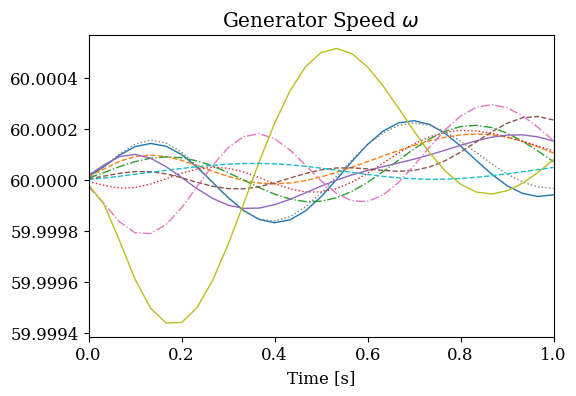

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feab4913e90>)

In [ ]:
ss.TDS.plt.plot(ss.GENROU.omega,
                ycalc=lambda x:60*x,
                title='Generator Speed $\omega$')

In [ ]:
ss.PVD1.pref0.v

array([0.69004982, 1.64182835, 1.87442435, 1.86527398, 1.42046891,
       2.01961911, 1.81212975, 1.79689992, 2.56877321, 0.04043839])

## Apply the control

In [ ]:

PQInit = np.array(ss.PQ.Ppf.v[PQStepIdx]).copy()
ss.PQ.Ppf.v[PQStepIdx] = PQ_after


pref0_init = ss.PVD1.pref0.v.copy()

In [ ]:
PQ_after

6

In [ ]:
step_t = 0.02
tstart =fault_time
TimeLength = tstart+10
idexs = np.arange(0,10)
for t in np.arange(tstart, TimeLength, step_t):
    ss.PVD1.pref0.v[idexs] = pref0_init[idexs]\
        -Action_RNN(w_plus_RNN, b_plus_RNN, w_minus_RNN, b_minus_RNN, pref0_init, idexs, max_action)
    ss.TDS.config.tf = t
    ss.TDS.run(tstep = 0.01)

100%|####################################| 100.0/100 [00:00<00:00, 134217.73%/s]
100%|#######################################| 100.0/100 [00:00<00:00, 940.02%/s]
100%|######################################| 100.0/100 [00:00<00:00, 1672.87%/s]
100%|######################################| 100.0/100 [00:00<00:00, 1492.49%/s]
100%|######################################| 100.0/100 [00:00<00:00, 1724.02%/s]
100%|######################################| 100.0/100 [00:00<00:00, 1348.00%/s]
100%|######################################| 100.0/100 [00:00<00:00, 1792.51%/s]
100%|######################################| 100.0/100 [00:00<00:00, 3084.84%/s]
100%|######################################| 100.0/100 [00:00<00:00, 2239.81%/s]
100%|######################################| 100.0/100 [00:00<00:00, 2633.65%/s]
100%|######################################| 100.0/100 [00:00<00:00, 3011.96%/s]
100%|######################################| 100.0/100 [00:00<00:00, 2745.74%/s]
100%|#######################

In [ ]:
if RecoverFlag:
    tstart =fault_time+10
    TimeLength = tstart+10
    ss.PQ.Ppf.v[PQStepIdx] = PQInit

    for t in np.arange(tstart, TimeLength, step_t):
        ss.PVD1.pref0.v[idexs] = pref0_init[idexs]\
            -Action_RNN(w_plus_RNN, b_plus_RNN, w_minus_RNN, b_minus_RNN, pref0_init, idexs, max_action)
        ss.TDS.config.tf = t
        ss.TDS.run()

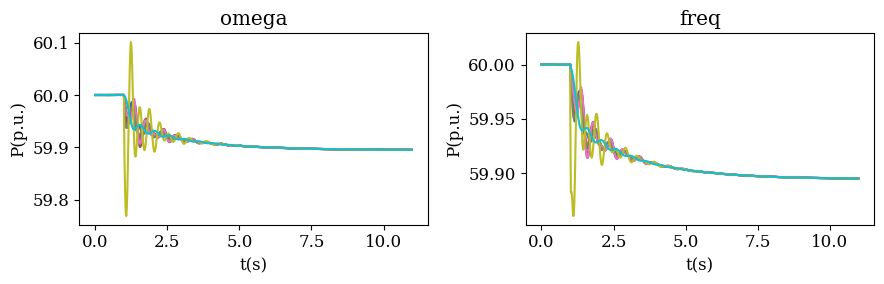

In [ ]:
ListTime = ss.dae.ts.t
ListFreq = ss.dae.ts.y[:,ss.BusFreq.f.a]*60 #Hz
ListOmega= ss.dae.ts.x[:,ss.GENROU.omega.a]*60 #Hz
plt_idx = np.arange(0,10)
TimeStep_start = 0
TimeStep = np.size(ListTime)
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListOmega[TimeStep_start:TimeStep, plt_idx], label='RotorFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.title('omega')
# plt.legend()

plt.subplot(1,2,2)
# TimeStep_start = 560
# TimeStep = 800
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListFreq[TimeStep_start:TimeStep, plt_idx], label='BusFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.title('freq')

# plt.legend()
fig.tight_layout()

## compare power command and output power

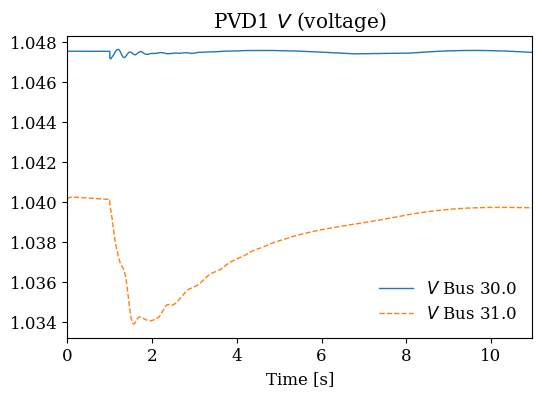

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feab49ed350>)

In [ ]:
ss.TDS.plt.plot(ss.PVD1.v,
                a=(0,1),
                title='PVD1 $V$ (voltage)')


In [ ]:
ListTime = ss.dae.ts.t
ListPVDV = ss.dae.ts.y[:,ss.PVD1.v.a]
ListPVDI = ss.dae.ts.x[:,ss.PVD1.Ipout_y.a]
ListPVDPower = ListPVDV*ListPVDI
ListPVDPowerCMD = ss.dae.ts.y[:,ss.PVD1.Psum.a]

In [ ]:
np.size(ListTime )

535

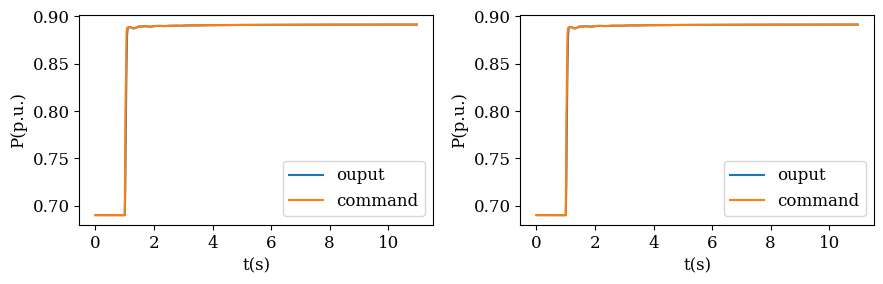

In [ ]:
plt_idx = [0]
TimeStep_start = 0
TimeStep = np.size(ListTime)
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListPVDPower[TimeStep_start:TimeStep, plt_idx], label='ouput')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListPVDPowerCMD[TimeStep_start:TimeStep, plt_idx], label='command')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.legend()

plt.subplot(1,2,2)
# TimeStep_start = 560
TimeStep = 800
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListPVDPower[TimeStep_start:TimeStep, plt_idx], label='ouput')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListPVDPowerCMD[TimeStep_start:TimeStep, plt_idx], label='command')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.legend()
fig.tight_layout()

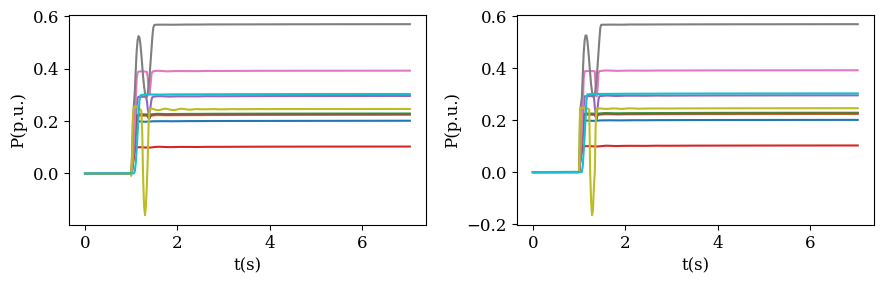

In [ ]:
plt_idx = np.arange(0, 10)
TimeStep_start = 0
TimeStep = np.size(ListTime)-200
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], \
         ListPVDPower[TimeStep_start:TimeStep, plt_idx]-ListPVDPower[0, plt_idx], label='ouput')
# plt.plot(ListTime[TimeStep_start:TimeStep], ListPVDPowerCMD[TimeStep_start:TimeStep, plt_idx], label='command')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
# plt.legend()

plt.subplot(1,2,2)
# TimeStep_start = 0
# TimeStep = 300
# plt.plot(ListTime[TimeStep_start:TimeStep], ListPVDPower[TimeStep_start:TimeStep, plt_idx], label='ouput')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], \
         ListPVDPowerCMD[TimeStep_start:TimeStep, plt_idx]-ListPVDPower[0, plt_idx], label='command')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
# plt.legend()
fig.tight_layout()

## Compare omega

In [ ]:
ss.BusFreq.f

Algeb: BusFreq.f, a=[481 482 483 484 485 486 487 488 489 490 491], v=[0.99825357 0.99825355 0.99825356 0.99825369 0.99825365 0.9982538
 0.99825387 0.9982536  0.99825377 0.99825355 0.99825347], e=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.22044605e-16  1.11022302e-16]

In [ ]:
ListTime = ss.dae.ts.t
ListFreq = ss.dae.ts.y[:,ss.BusFreq.f.a]*60 #Hz
ListOmega= ss.dae.ts.x[:,ss.GENROU.omega.a]*60 #Hz


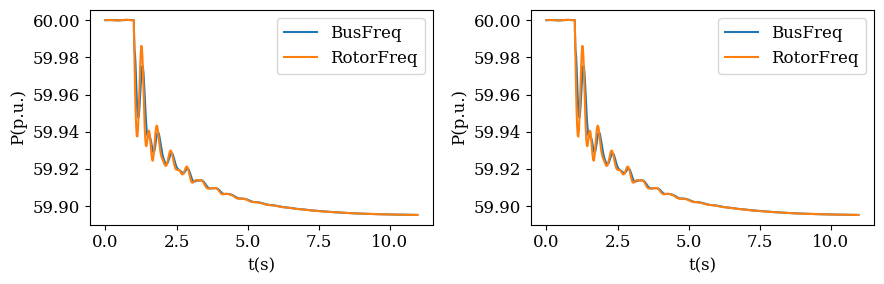

In [ ]:
plt_idx = [0]
TimeStep_start = 0
TimeStep = np.size(ListTime)
fig = plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1,2,1)

plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListFreq[TimeStep_start:TimeStep, plt_idx], label='BusFreq')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListOmega[TimeStep_start:TimeStep, plt_idx], label='RotorFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.legend()

plt.subplot(1,2,2)
TimeStep_start = 0
TimeStep = np.size(ListTime)
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListFreq[TimeStep_start:TimeStep, plt_idx], label='BusFreq')
plt.plot(ListTime[TimeStep_start:TimeStep]-ListTime[TimeStep_start ], ListOmega[TimeStep_start:TimeStep, plt_idx], label='RotorFreq')
plt.xlabel('t(s)')
plt.ylabel('P(p.u.)')
plt.legend()
fig.tight_layout()